In [1]:
%run ../0-utils/0-Base.ipynb

Read data that will be used for training / testing:

In [2]:
%%time

feature_matrix_dfs = dict()

for feature_matrix_clazz in ("train", "test"):
    feature_matrix_df = pd.read_csv(f"../data/2-feature-engineered/{feature_matrix_clazz}.csv")
    feature_matrix_df = feature_matrix_df.drop("MODE(transactions.merchant_id)", axis=1)
    feature_matrix_df = feature_matrix_df.set_index("card_id")
    
    display(feature_matrix_df)

    feature_matrix_dfs[feature_matrix_clazz] = feature_matrix_df

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),PERCENT_TRUE(transactions.installments_-1),PERCENT_TRUE(transactions.installments_0),PERCENT_TRUE(transactions.installments_1),PERCENT_TRUE(transactions.installments_2),PERCENT_TRUE(transactions.installments_3),PERCENT_TRUE(transactions.installments_4),PERCENT_TRUE(transactions.installments_5),PERCENT_TRUE(transactions.installments_6),PERCENT_TRUE(transactions.installments_7),PERCENT_TRUE(transactions.installments_8),PERCENT_TRUE(transactions.installments_9),PERCENT_TRUE(transactions.installments_10),PERCENT_TRUE(transactions.installments_11),PERCENT_TRUE(transactions.installments_12),PERCENT_TRUE(transactions.installments_999),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.installments),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.installments),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE installments_10 = 1),COUNT(transactions WHERE installments_8 = 1),COUNT(transactions WHERE installments_11 = 1),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE installments_6 = 1),COUNT(transactions WHERE installments_999 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE installments_2 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE installments_9 = 1),COUNT(transactions WHERE installments_3 = 1),COUNT(transactions WHERE category_2_5 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE installments_-1 = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE installments_12 = 1),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE installments_0 = 1),COUNT(transactions WHERE installments_1 = 1),COUNT(transactions WHERE installments_7 = 1),COUNT(transactions WHERE installments_5 = 1),COUNT(transactions WHERE installments_4 = 1),COUNT(transactions WHERE category_3_1 = 1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
card_id,,,,,,

,target,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_2_1,feature_2_2,feature_2_3,feature_1,feature_2,feature_3,SUM(transactions.month_lag),SUM(transactions.purchase_amount),SUM(transactions.month_diff),STD(transactions.month_lag),STD(transactions.purchase_amount),STD(transactions.month_diff),MAX(transactions.month_lag),MAX(transactions.purchase_amount),MAX(transactions.month_diff),SKEW(transactions.month_lag),SKEW(transactions.purchase_amount),SKEW(transactions.month_diff),MIN(transactions.month_lag),MIN(transactions.purchase_amount),MIN(transactions.month_diff),MEAN(transactions.month_lag),MEAN(transactions.purchase_amount),MEAN(transactions.month_diff),COUNT(transactions),PERCENT_TRUE(transactions.authorized_flag),PERCENT_TRUE(transactions.category_1),PERCENT_TRUE(transactions.category_2_1),PERCENT_TRUE(transactions.category_2_2),PERCENT_TRUE(transactions.category_2_3),PERCENT_TRUE(transactions.category_2_4),PERCENT_TRUE(transactions.category_2_5),PERCENT_TRUE(transactions.category_2_-1),PERCENT_TRUE(transactions.category_3_0),PERCENT_TRUE(transactions.category_3_1),PERCENT_TRUE(transactions.category_3_2),PERCENT_TRUE(transactions.category_3_-1),PERCENT_TRUE(transactions.installments_-1),PERCENT_TRUE(transactions.installments_0),PERCENT_TRUE(transactions.installments_1),PERCENT_TRUE(transactions.installments_2),PERCENT_TRUE(transactions.installments_3),PERCENT_TRUE(transactions.installments_4),PERCENT_TRUE(transactions.installments_5),PERCENT_TRUE(transactions.installments_6),PERCENT_TRUE(transactions.installments_7),PERCENT_TRUE(transactions.installments_8),PERCENT_TRUE(transactions.installments_9),PERCENT_TRUE(transactions.installments_10),PERCENT_TRUE(transactions.installments_11),PERCENT_TRUE(transactions.installments_12),PERCENT_TRUE(transactions.installments_999),NUM_UNIQUE(transactions.city_id),NUM_UNIQUE(transactions.merchant_category_id),NUM_UNIQUE(transactions.merchant_id),NUM_UNIQUE(transactions.state_id),NUM_UNIQUE(transactions.subsector_id),NUM_UNIQUE(transactions.installments),NUM_UNIQUE(transactions.category_2),NUM_UNIQUE(transactions.category_3),MODE(transactions.city_id),MODE(transactions.merchant_category_id),MODE(transactions.state_id),MODE(transactions.subsector_id),MODE(transactions.installments),MODE(transactions.category_2),MODE(transactions.category_3),DAY(first_active_month),YEAR(first_active_month),MONTH(first_active_month),WEEKDAY(first_active_month),COUNT(transactions WHERE authorized_flag = 1),COUNT(transactions WHERE installments_10 = 1),COUNT(transactions WHERE installments_8 = 1),COUNT(transactions WHERE installments_11 = 1),COUNT(transactions WHERE category_1 = 1),COUNT(transactions WHERE installments_6 = 1),COUNT(transactions WHERE installments_999 = 1),COUNT(transactions WHERE category_3_-1 = 1),COUNT(transactions WHERE category_2_-1 = 1),COUNT(transactions WHERE category_3_0 = 1),COUNT(transactions WHERE installments_2 = 1),COUNT(transactions WHERE category_2_1 = 1),COUNT(transactions WHERE installments_9 = 1),COUNT(transactions WHERE installments_3 = 1),COUNT(transactions WHERE category_2_5 = 1),COUNT(transactions WHERE category_2_4 = 1),COUNT(transactions WHERE category_3_2 = 1),COUNT(transactions WHERE installments_-1 = 1),COUNT(transactions WHERE category_2_2 = 1),COUNT(transactions WHERE installments_12 = 1),COUNT(transactions WHERE category_2_3 = 1),COUNT(transactions WHERE installments_0 = 1),COUNT(transactions WHERE installments_1 = 1),COUNT(transactions WHERE installments_7 = 1),COUNT(transactions WHERE installments_5 = 1),COUNT(transactions WHERE installments_4 = 1),COUNT(transactions WHERE category_3_1 = 1),NUM_UNIQUE(transactions.DAY(purchase_date)),NUM_UNIQUE(transactions.YEAR(purchase_date)),NUM_UNIQUE(transactions.MONTH(purchase_date)),NUM_UNIQUE(transactions.WEEKDAY(purchase_date)),MODE(transactions.DAY(purchase_date)),MODE(transactions.YEAR(purchase_date)),MODE(transactions.MONTH(purchase_date)),MODE(transactions.WEEKDAY(purchase_date))
card_id,,,,,,

CPU times: user 3.46 s, sys: 224 ms, total: 3.68 s
Wall time: 3.68 s


Check for missing values:

In [3]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    print(feature_matrix_clazz.upper() + ":")
    
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    display(cols_with_nulls)

TRAIN:


['SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)']

TEST:


['SKEW(transactions.month_lag)',
 'SKEW(transactions.purchase_amount)',
 'SKEW(transactions.month_diff)']

Get rid of missing values:

In [4]:
for feature_matrix_clazz, feature_matrix_df in feature_matrix_dfs.items():
    cols_with_nulls = feature_matrix_df.columns[feature_matrix_df.isnull().any()].tolist()
    
    for skew_col in filter(lambda x: x.startswith("SKEW"), cols_with_nulls):
        feature_matrix_df[skew_col].fillna(feature_matrix_df[skew_col].mode()[0], inplace=True)
    
    print(f"{feature_matrix_clazz.upper()} has {feature_matrix_df.isnull().sum().sum()} missing values!")

TRAIN has 0 missing values!
TEST has 0 missing values!


In [38]:
X_train, y_train = feature_matrix_dfs["train"].drop("target", axis=1), feature_matrix_dfs["train"].target

X_train_ordinal, y_train_ordinal = X_train[y_train > -33], y_train[y_train > -33]
X_train_anomaly, y_train_anomaly = X_train[y_train < -33], y_train[y_train < -33]

X_test = feature_matrix_dfs["test"].drop("target", axis=1)

In [6]:
%%time

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, max_features="log2", max_depth=10, n_jobs=-1, random_state=13)
scores = np.sqrt(-cross_val_score(model, X_train_ordinal, y_train_ordinal, scoring="neg_mean_squared_error"))
print("CV: %.4f +/- %.4f" % (scores.mean(), scores.std() ** 2))

CV: 1.7037 +/- 0.0000
CPU times: user 7.06 s, sys: 629 ms, total: 7.69 s
Wall time: 24.2 s


In [7]:
%%time

model.fit(X_train_ordinal, y_train_ordinal)

CPU times: user 1min 32s, sys: 149 ms, total: 1min 32s
Wall time: 12 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

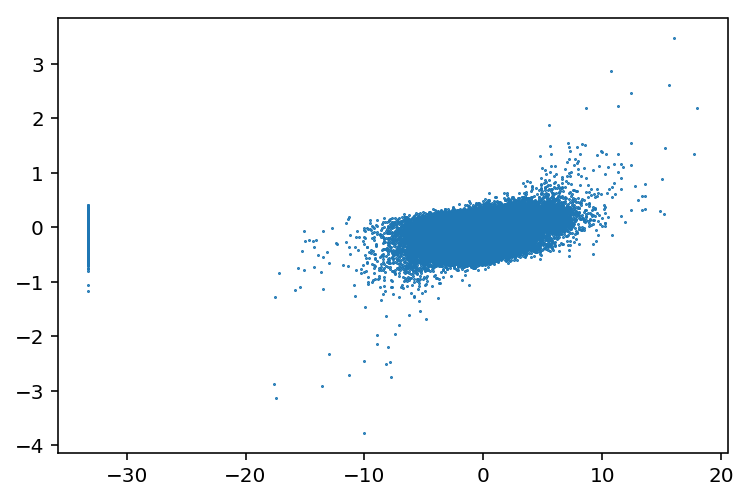

In [8]:
plt.scatter(y_train, model.predict(X_train), s=0.25);

In [39]:
%%time

y_test = model.predict(X_test)

CPU times: user 3.43 s, sys: 60.2 ms, total: 3.49 s
Wall time: 572 ms


In [40]:
%%time

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

anomaly_classifier = RandomForestClassifier(n_estimators=200,
                                            max_features="log2",
                                            random_state=13,
                                            max_depth=10,
                                            n_jobs=-1)

X_train, y_train = shuffle(X_train, y_train)
y_train = (y_train < -33).astype(np.int)

scores = cross_val_score(anomaly_classifier, X_train, y_train, cv=5)
print("CV: %.4f +/- %.4f" % (scores.mean(), scores.std() ** 2))

CV: 0.9891 +/- 0.0000
CPU times: user 9.69 s, sys: 854 ms, total: 10.5 s
Wall time: 57.2 s


In [41]:
%%time

anomaly_classifier.fit(X_train, y_train)
mask = anomaly_classifier.predict(X_test)

y_test[mask == 1] = feature_matrix_dfs["train"].target.min()

CPU times: user 1min 57s, sys: 141 ms, total: 1min 57s
Wall time: 15.3 s


In [42]:
submission_df = feature_matrix_dfs["test"].assign(target=y_test).loc[:, ["target"]]

display(submission_df)
    
submission_df.to_csv("../submission.csv")

,target
card_id,
C_ID_0079d1f5ee,-0.035806
C_ID_00d20cfaa6,-0.076654
C_ID_023ee72d50,0.007727
...,...
C_ID_fe91e3fc9f,0.046165
C_ID_ff02b057f5,0.013292
C_ID_ffbb1f9527,0.107973
